## Introduction Examples

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.utils.random import sample_without_replacement
from imblearn.under_sampling import RandomUnderSampler

N = 100000
X, y = make_blobs(n_samples=N, n_features=2, centers=[[0, 0]], cluster_std=3, random_state=2)
mins = X.min(axis=0)
maxs = X.max(axis=0)

def add_noise(X, y):
  X2 = np.random.rand(int(N * 0.2), 2)
  y2 = np.full(int(N * 0.2), -1)
  X2[:, 0] = (X2[:, 0] * (maxs[0] - mins[0])) + mins[0]
  X2[:, 1] = (X2[:, 1]) * (maxs[1] - mins[1]) + mins[1]

  X_ = np.concatenate([X, X2], axis=0)
  y_ = np.concatenate([y, y2], axis=0)
  return X_, y_

X, y = add_noise(X, y)


def cluster(X, y):
  clustering = DBSCAN(eps=0.32, min_samples=100).fit(X)
  c = clustering.labels_
  return c


def to_df(X, y):
  df = pd.DataFrame(X, columns=["A, B"])
  df["y"] = y
  return df


def draw_uniform_sample(X, y, n_sample: int):
  # shuffle the input data
  random = np.random.rand(len(X))
  random_order = np.argsort(random)
  X_ = X[random_order]

  # draw random sample
  sample = sample_without_replacement(n_population=len(X_), n_samples=n_sample, random_state=0)

  return to_df(X[sample], y[sample])


def draw_inlier_sample(X, y, n_sample: int):
  # dbscan: -1 is outlier, so inlier is > -1
  c = cluster(X, y)
  c = (c > -1).astype(int)

  # in case there are more than n_sample inliers, sample down uniformly
  return draw_uniform_sample(X[c == 1], c[c == 1], n_sample=n_sample)


def draw_stratified_sample(X, y, n_sample: int):
  c = cluster(X, y)
  c = (c > -1).astype(int)
  
  # clustering might find more than 2 clusters, but all we need is inlier/outliere(int)

  rus = RandomUnderSampler()
  X_, y_ = rus.fit_resample(X, c)
  return draw_uniform_sample(X_, y_, n_sample=n_sample)


def draw_noise_sample(X, y, n_sample: int):
  c = cluster(X, y)
  c = (c > -1).astype(int)
  
  return draw_uniform_sample(X[y == -1], c[y == -1], n_sample)


def draw_outlier_sample(X, y, n_sample: int):
  # dbscan: -1 is outlier, so inlier is > -1
  c = cluster(X, y).astype(int)

  return draw_uniform_sample(X[c == -1], c[c == -1], n_sample)

### Plot full dataset

(-12.48393401358247, 14.190341438793237)

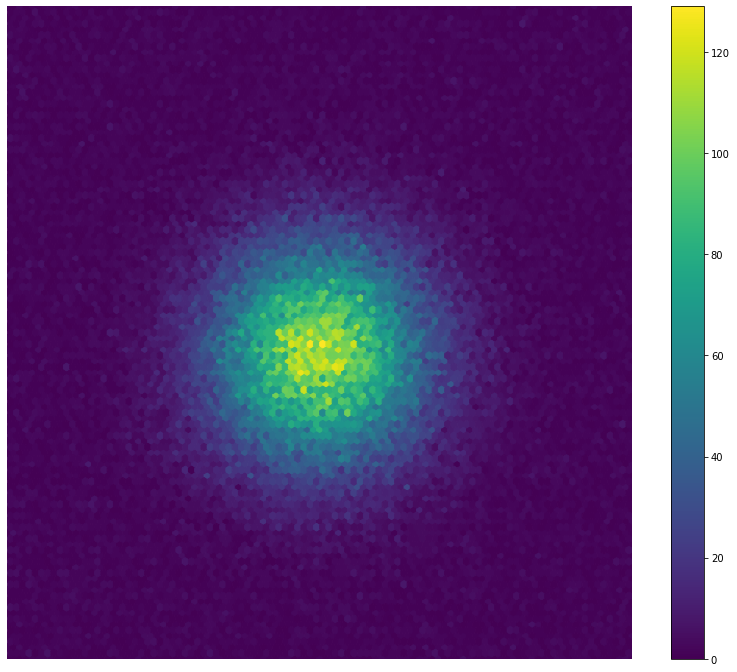

In [4]:
df = pd.DataFrame(X, columns=["A, B"])
plt = df.plot.hexbin(
  x='A',
  y='B',
  reduce_C_function=np.sum,
  gridsize=100,
  cmap="viridis",
  figsize=[14, 12],
)

plt.axis("off")
plt.set_xlim([mins[0], maxs[0]])
plt.set_ylim([mins[1], maxs[1]])

### Plot different sampling tasks on that dataset

(-12.48393401358247, 14.190341438793237)

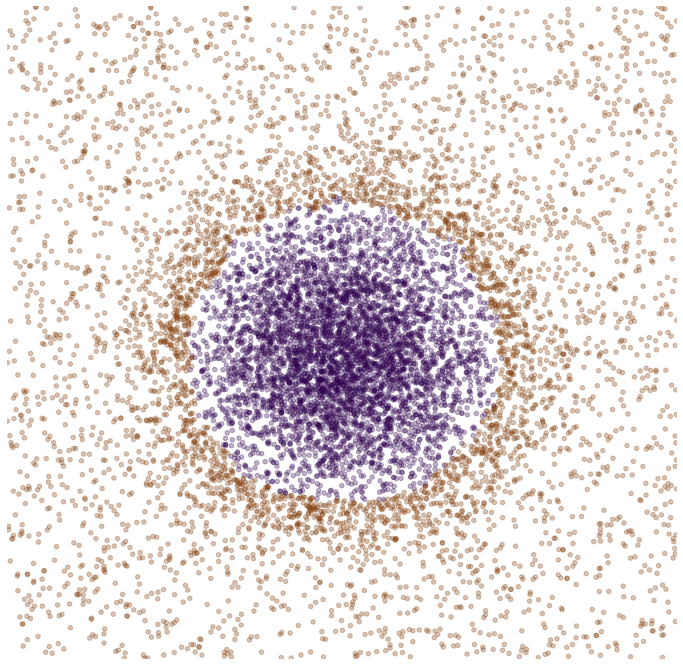

In [3]:
# plot a sampling
# df = draw_noise_sample(X, y, 10000)
df = draw_stratified_sample(X, y, 10000)
# df = draw_outlier_sample(X, y, 10000)
# df = draw_inlier_sample(X, y, 10000)
# df = draw_uniform_sample(X, y, 10000)

plt = df.plot.scatter(
  x="A", 
  y="B", 
  # c="#2f124b", 
  c="y",
  colormap="PuOr", 
  alpha=0.3, 
  figsize=[12, 12], 
  colorbar=False,
)

plt.axis("off")
plt.set_xlim([mins[0], maxs[0]])
plt.set_ylim([mins[1], maxs[1]])

### Sampling the same dataset by different data types

In [5]:
import pandas as pd
from datetime import datetime

# source 2018 yellow cab taxi rides (112M lines):
# https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq
# source taxi zones:
# https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
rides_df = pd.read_csv("./linearizations/input_files/taxis.csv", delimiter=", ")
zones_df = pd.read_csv("./linearizations/input_files/taxi_zones.csv")

pd.to_datetime(rides_df["tpep_pickup_datetime"].loc[:100]).max()

C:\Users\au629923\AppData\Local\Temp\ipykernel_18880\2725330863.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  rides_df = pd.read_csv("./linearizations/input_files/taxis.csv", delimiter=", ")

KeyboardInterrupt



### Comparing distribution of three linearizations

In [2]:
import os, sys
sys.path.append(f"{os.getcwd()}/../")

from pipeline.Pipeline import Pipeline

config1 = {
  "data": "taxis",
  "dimension": 0,
  "linearization": "z-order",
  "subdivision": "standard",
  "selection": "first",
  "params": {}
}

config2 = {
  "data": "taxis",
  "dimension": 0,
  "linearization": "numeric",
  "subdivision": "standard",
  "selection": "first",
  "params": {}
}

config3 = {
  "data": "taxis",
  "dimension": 0,
  "linearization": "temporal",
  "subdivision": "standard",
  "selection": "first",
  "params": {}
}

pipeline1 = Pipeline(config1)
pipeline2 = Pipeline(config2)
pipeline3 = Pipeline(config3)

preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing
preprocessing pipeline ...
Done with the pre-processing


0 0.0
1 -0.00022544582058908053
2 0.0


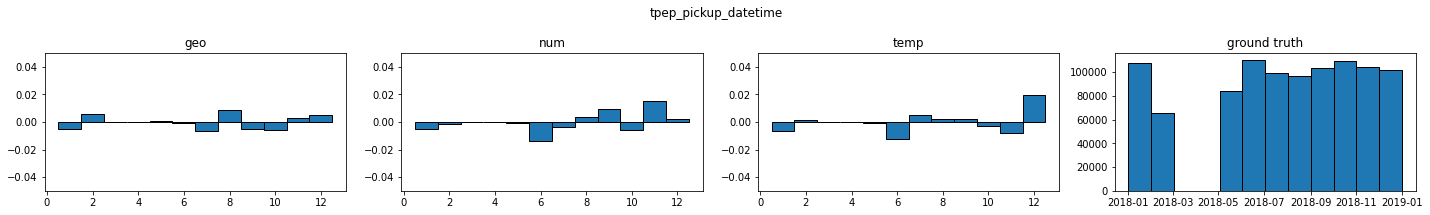

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def hist(sample_df: pd.Series, value_range: tuple, n_bins, ax: plt):
  return ax.hist(
    sample_df, 
    bins=n_bins,
    range=value_range,
    edgecolor='black', 
    linewidth=1
  )

def delta_hist(delta: pd.Series, ax: plt):
  return ax.bar(
    delta.index,
    delta,
    width=1,
    edgecolor='black', 
    linewidth=1,
  )

def boxplot(sample_df: pd.DataFrame, ax: plt):
  n_bins = 100
  return ax.boxplot(
    sample_df,
    labels=sample_df.columns
  )


columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]


def plot_boxplot(attr: str):
  fig, ax = plt.subplots(n_chunks, 1, figsize=(5, n_chunks * 3))
  fig.suptitle(attr)
  ground_truth_df = pd.DataFrame(pipeline1.subdivision.linearization, columns=columns)[attr]
  
  for i in range(n_chunks):
    ax[i].set_title(f"chunk {i}")

    df = pd.DataFrame()
    df["geo"] = pd.DataFrame(pipeline1.get_next_chunk(), columns=columns)[attr]
    df["num"] = pd.DataFrame(pipeline2.get_next_chunk(), columns=columns)[attr]
    df["temp"] = pd.DataFrame(pipeline3.get_next_chunk(), columns=columns)[attr]
    df["ground_truth"] = ground_truth_df
    boxplot(df, ax[i])

  plt.tight_layout()
  plt.show()


def plot_time_hist(attr: str):
  fig, ax = plt.subplots(1, 4, figsize=(20, 3))
  fig.suptitle(attr)
  date_range = ("2018-01-01 00:00:00", "2018-12-31 23:59:59")

  geo_df = pd.Series(dtype="float64")
  num_df = pd.Series(dtype="float64")
  temp_df = pd.Series(dtype="float64")

  for i in range(n_chunks):
    chunk_geo = pd.to_datetime(pd.DataFrame(pipeline1.get_next_chunk(), columns=columns)[attr])
    chunk_num = pd.to_datetime(pd.DataFrame(pipeline2.get_next_chunk(), columns=columns)[attr])
    chunk_temp = pd.to_datetime(pd.DataFrame(pipeline3.get_next_chunk(), columns=columns)[attr])

    geo_df = pd.concat([geo_df, chunk_geo])
    num_df = pd.concat([num_df, chunk_num])
    temp_df = pd.concat([temp_df, chunk_temp])

  ground_truth_df = pd.to_datetime(pd.DataFrame(pipeline1.subdivision.linearization, columns=columns)[attr])
  gt_monthly_dist = ground_truth_df.dt.month.value_counts(normalize=True).sort_index()

  for i, df in enumerate([geo_df, num_df, temp_df]):
    monthly_dist = df.dt.month.value_counts(normalize=True).sort_index()

    delta = monthly_dist - gt_monthly_dist
    for j in range(1, 13):
      delta.loc[j] = delta.loc[j] if j in delta.index else 0

    ax[i].set_ylim(-0.05, 0.05)
    print(i, delta.median())
    delta_hist(delta, ax[i])

  hist(ground_truth_df, date_range, 12, ax[3])

  for ax_, col in zip(ax, ["geo", "num", "temp", "ground truth"]):
    ax_.set_title(col)

  plt.tight_layout()
  plt.show()


n_chunks = 2
plot_time_hist("tpep_pickup_datetime")
# plot_boxplot("tpep_pickup_datetime")

A conclusion from the above is that simply linearizing by a temporal dimension does not necessarily produce better results. 
In fact, the mean/median error between the three pipelines is more or less the same. 
But, since the pipeline is modular, we can turn this sampling over uniformly distributed bins into a *stratified sampling* by exchanging the subdivision step, creating bins for each month.

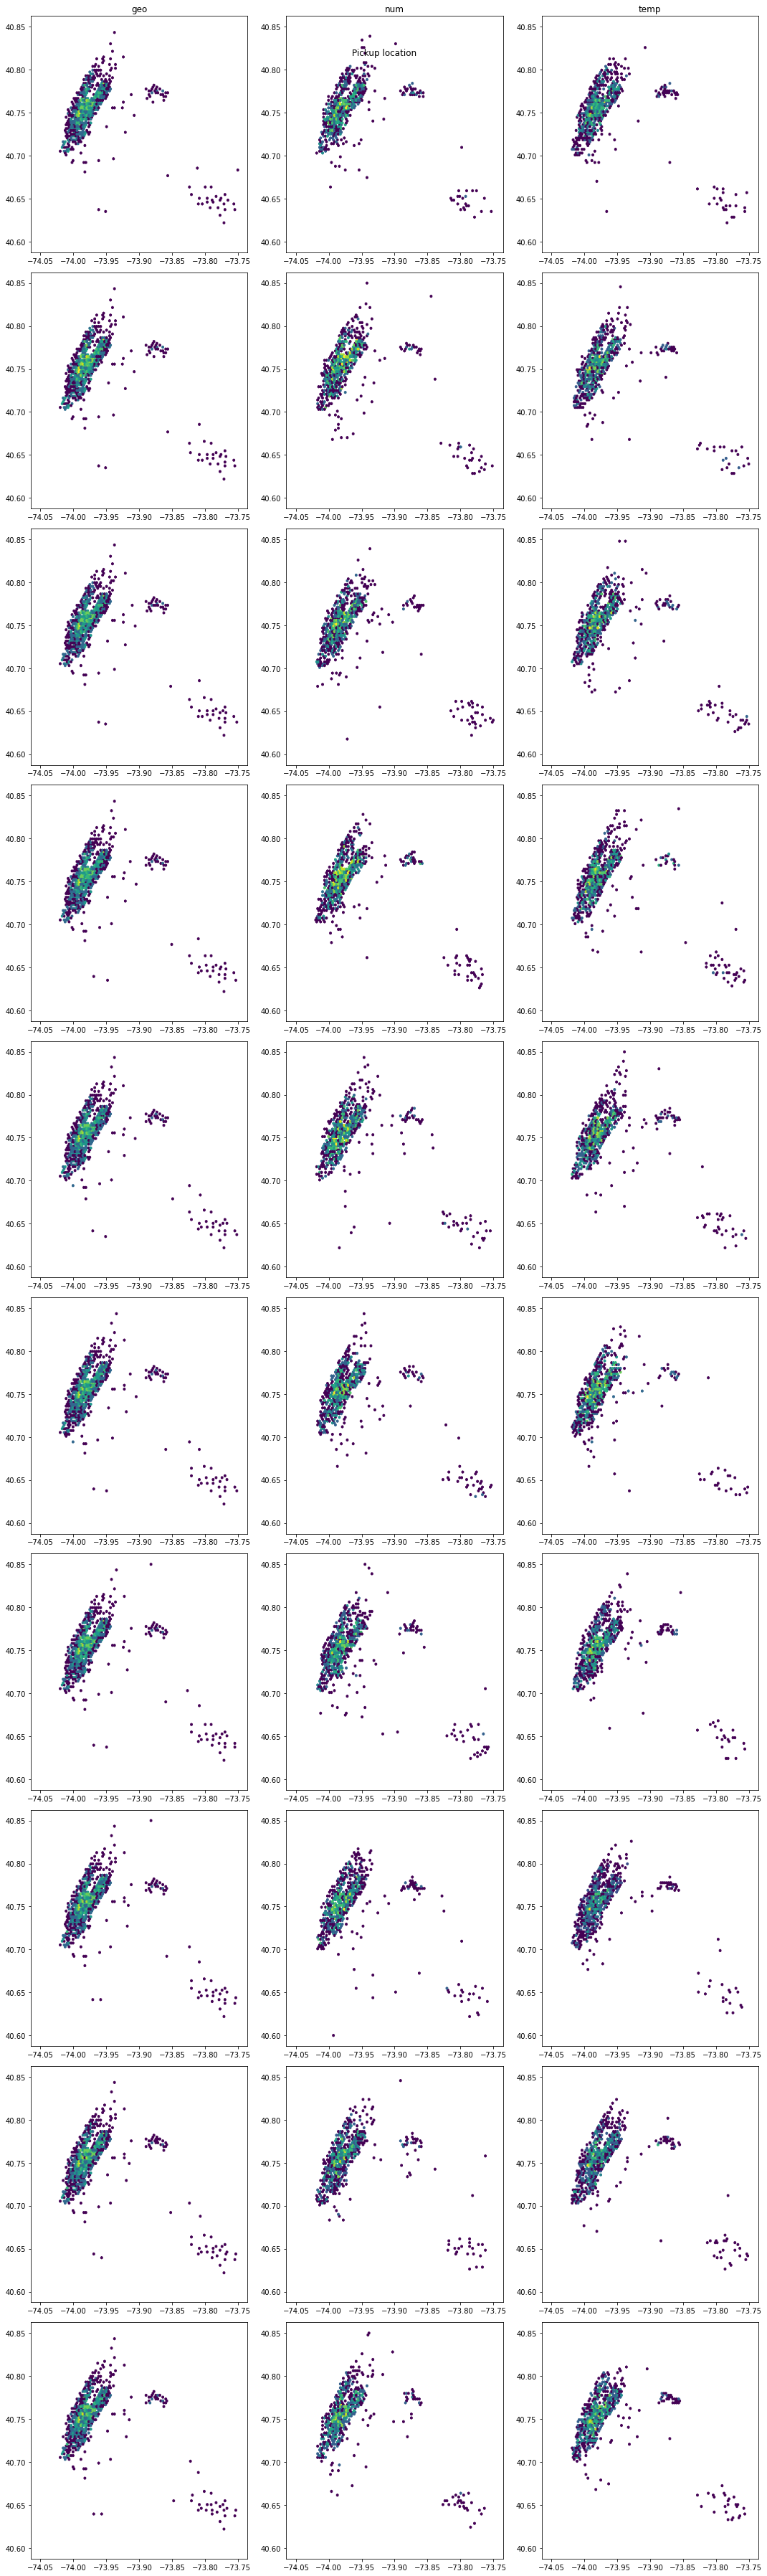

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def geo_hexbin(sample_df: pd.DataFrame, ax: plt):
  return ax.hexbin(
    x=sample_df["PURepresentativeX"], 
    y=sample_df["PURepresentativeY"],
    bins="log",
    mincnt=1,
    gridsize=100,
    extent=[-74.05, -73.75, 40.6, 40.85]
  )


columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]

def plot_geo():
  fig, ax = plt.subplots(n_chunks, 3, figsize=(15, n_chunks * 5))
  fig.suptitle("Pickup location")

  for i in range(n_chunks):
    chunk_geo = pd.DataFrame(pipeline1.get_next_chunk(), columns=columns)
    chunk_num = pd.DataFrame(pipeline2.get_next_chunk(), columns=columns)
    chunk_temp = pd.DataFrame(pipeline3.get_next_chunk(), columns=columns)

    geo_hexbin(chunk_geo, ax[i][0])
    geo_hexbin(chunk_num, ax[i][1])
    geo_hexbin(chunk_temp, ax[i][2])

  for ax_, col in zip(ax[0], ["geo", "num", "temp"]):
    ax_.set_title(col)
  
  plt.tight_layout()
  plt.show()

n_chunks = 10
plot_geo()

A conclusion from this test is that by linearizing along the geospatial attribute, we can ensure a relatively consistent distribution across consecutive chunks. 
Comparing `geo` to the other two classes, we can see that in particular the regions around the two airports La Guardia and JFK, the points in the sparse areas, and the outliers around Manhattan are more consistent.
We get this spatial consistency from the z-order curve.

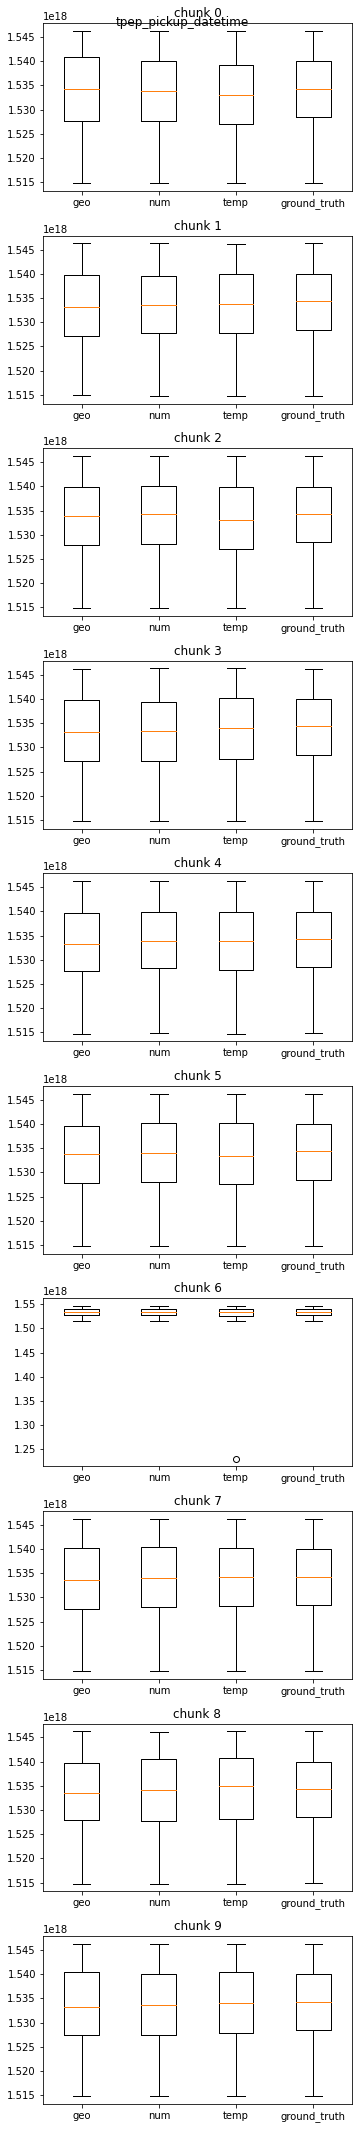

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def boxplot(sample_df: pd.DataFrame, ax: plt):
  n_bins = 100
  return ax.boxplot(
    sample_df,
    labels=sample_df.columns
  )


columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]


def plot_boxplot(attr: str):
  fig, ax = plt.subplots(n_chunks, 1, figsize=(5, n_chunks * 3))
  fig.suptitle(attr)
  ground_truth_df = pd.DataFrame(pipeline1.subdivision.linearization, columns=columns)[attr]
  
  for i in range(n_chunks):
    ax[i].set_title(f"chunk {i}")

    df = pd.DataFrame()
    df["geo"] = pd.DataFrame(pipeline1.get_next_chunk(), columns=columns)[attr]
    df["num"] = pd.DataFrame(pipeline2.get_next_chunk(), columns=columns)[attr]
    df["temp"] = pd.DataFrame(pipeline3.get_next_chunk(), columns=columns)[attr]
    df["ground_truth"] = ground_truth_df
    boxplot(df, ax[i])

  plt.tight_layout()
  plt.show()


n_chunks = 10
plot_boxplot("tpep_pickup_datetime")

In [27]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

date_range = ("2018-01-01 00:00:00", "2018-12-31 23:59:59")

columns = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PURepresentativeX", "PURepresentativeY", "DORepresentativeX", "DORepresentativeY"]

df = pd.read_csv("./linearization_files/taxisLinearizationZOrder.csv", delimiter=";", names=columns)
